In [ ]:
import numpy as np
import pandas as pd 
import ydata_profiling
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit,mnlogit
import itertools

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score
from sklearn import linear_model

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: ignored

In [ ]:
df= pd.read_csv('forecasting_case_study.csv')

In [ ]:
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0


In [ ]:
profile= df.profile_report(title='Retail Forcasting', explorative=True)

In [ ]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1218 non-null   object 
 1   date                1218 non-null   object 
 2   Sales               1218 non-null   int64  
 3   Price Discount (%)  1218 non-null   object 
 4   In-Store Promo      1218 non-null   int64  
 5   Catalogue Promo     1218 non-null   int64  
 6   Store End Promo     1218 non-null   int64  
 7   Google_Mobility     1218 non-null   float64
 8   Covid_Flag          1218 non-null   int64  
 9   V_DAY               1218 non-null   int64  
 10  EASTER              1218 non-null   int64  
 11  CHRISTMAS           1218 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 114.3+ KB


In [ ]:
def date_clean(df):
    df["date"] =  pd.to_datetime(df["date"])
    df['month'] = df["date"].apply(lambda t: t.month)
    df['day_week'] = df["date"].apply(lambda x: x.weekday()+1)
    df["discount"] = df["Price Discount (%)"].str.rstrip('%').astype(int)/100
    return df

In [ ]:
df = date_clean(df)

In [ ]:
df["Product"].nunique()

6

In [ ]:
df["Google_Mobility"].nunique()

48

## EDA

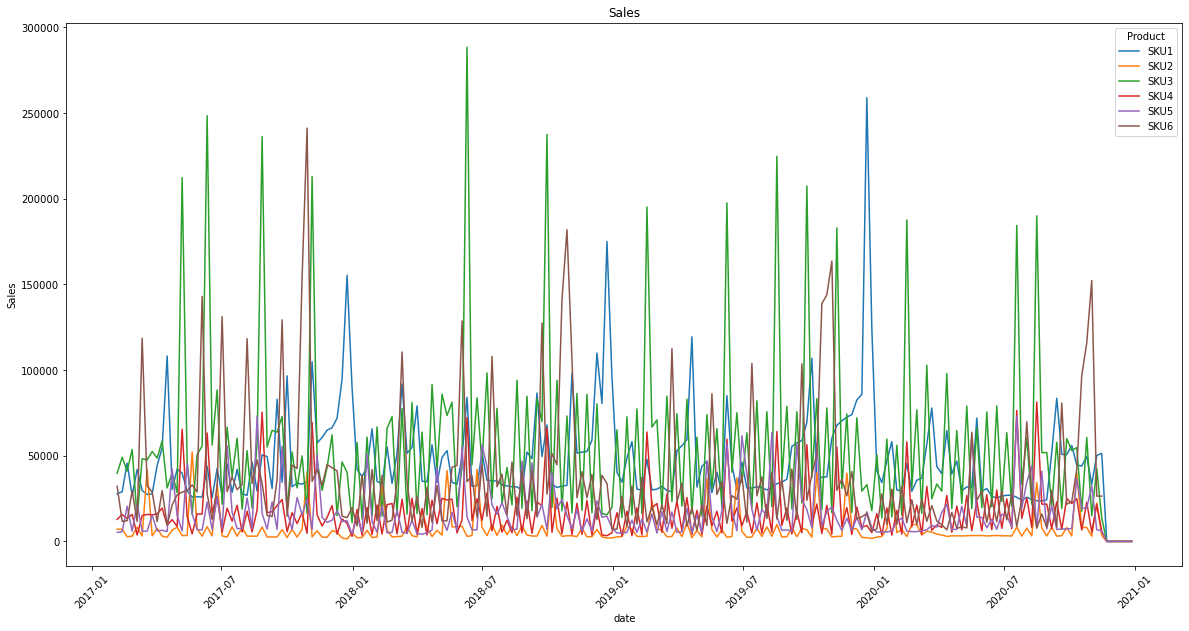

In [ ]:
#overall distribution for each product sales
plt.figure(figsize = (20,10))
g=sns.lineplot(x="date",y="Sales",hue="Product",data=df)
g.set_title("Sales")
plt.xticks(rotation=45)
plt.show()

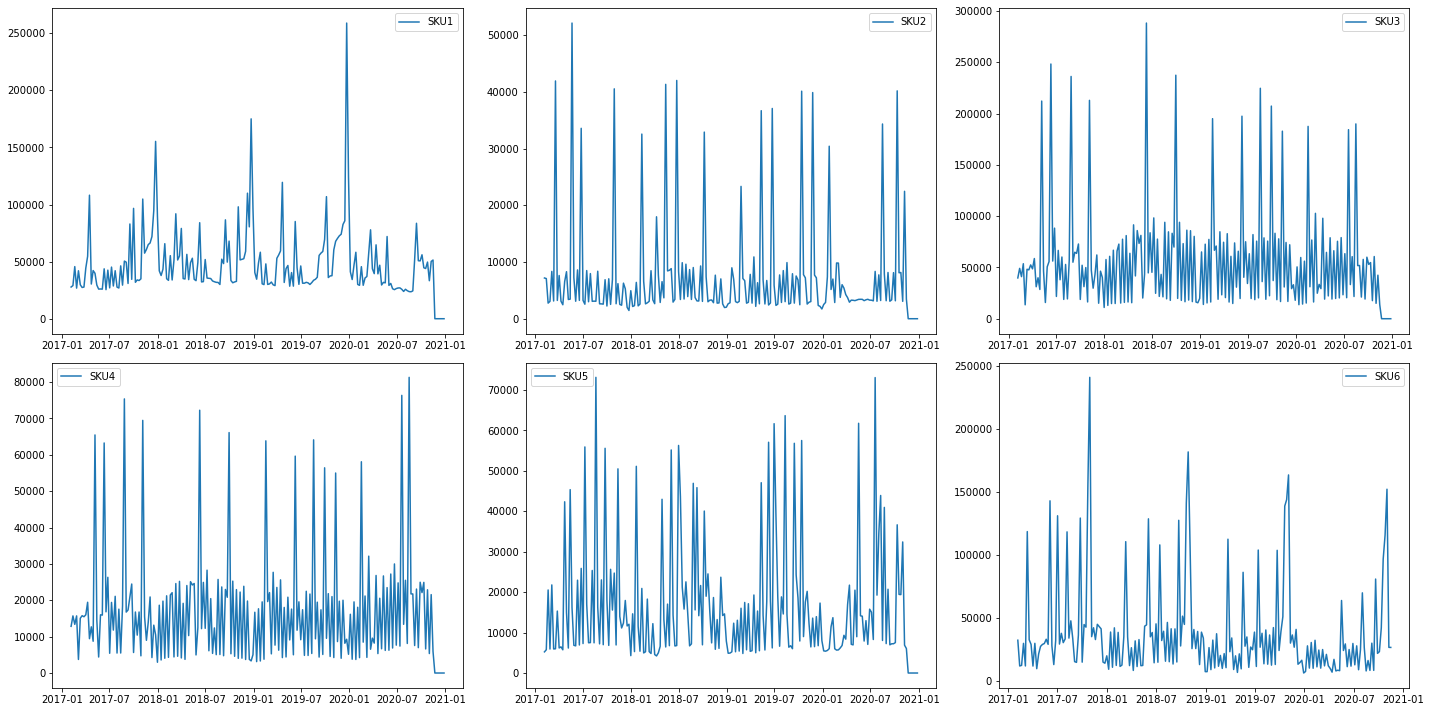

In [ ]:
products = df["Product"].unique()

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i, product in enumerate(products):
    axs[i].plot(df[df["Product"]==product]["date"], df[df["Product"]==product]["Sales"], label=product)
    axs[i].legend()
        
plt.tight_layout()
plt.show()

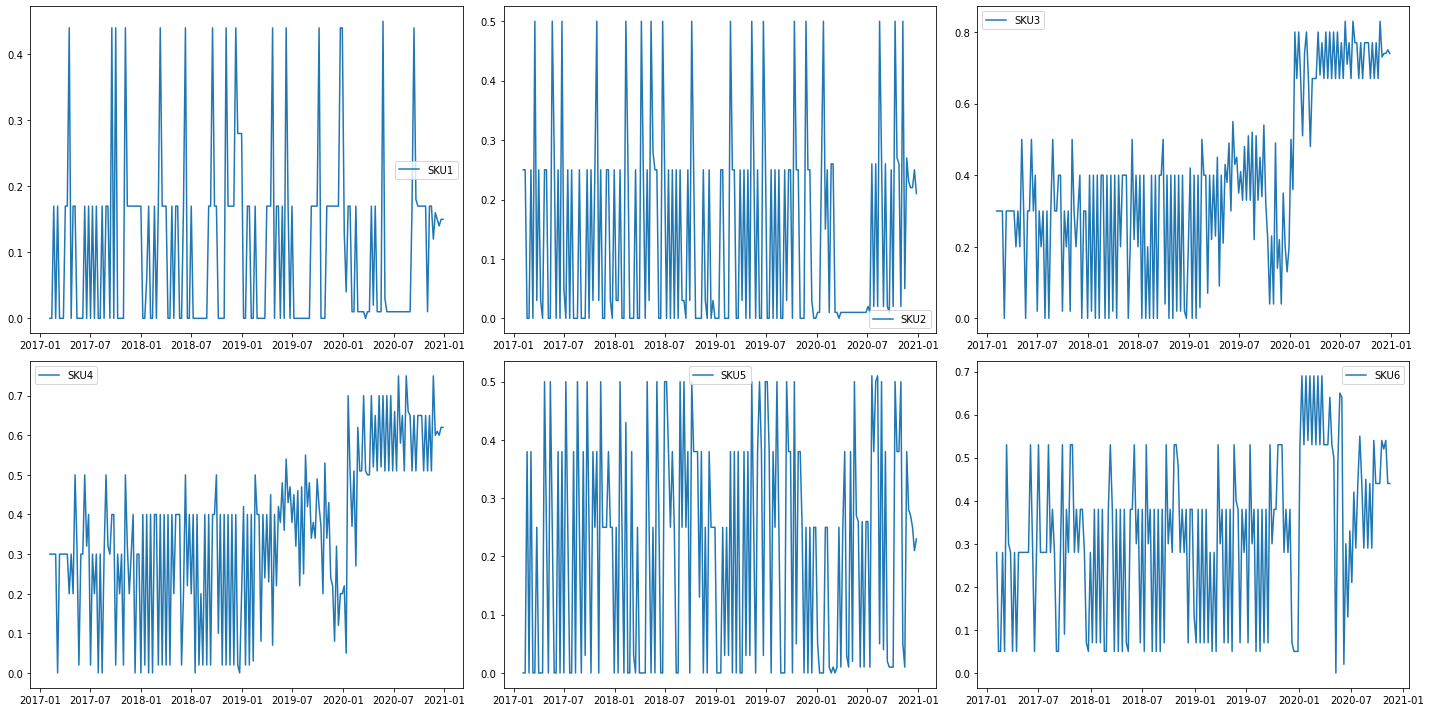

In [ ]:
products = df["Product"].unique()

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.ravel()

for i, product in enumerate(products):
    axs[i].plot(df[df["Product"]==product]["date"], df[df["Product"]==product]["discount"], label=product)
    axs[i].legend()
        
plt.tight_layout()
plt.show()

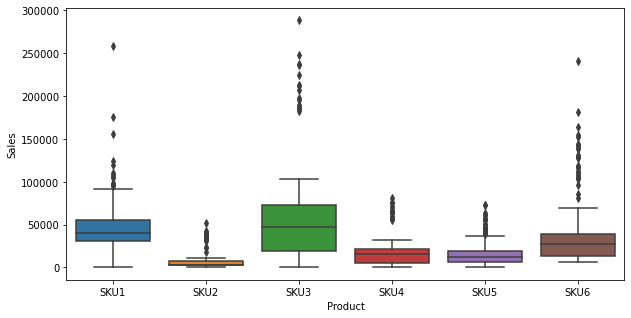

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Product', y='Sales', data=df)
plt.show()

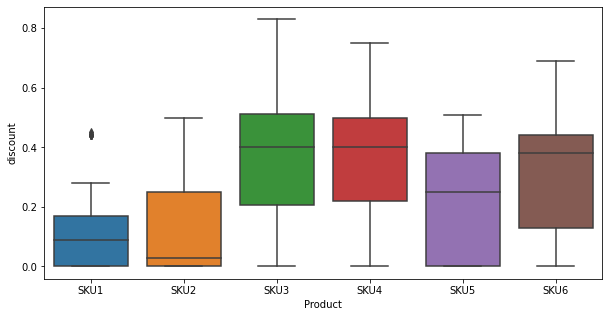

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Product', y='discount', data=df)
plt.show()

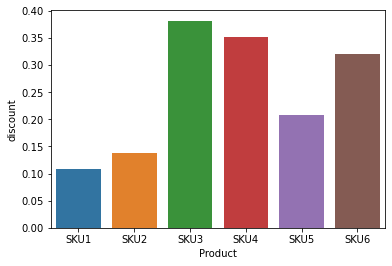

In [ ]:
dp = pd.DataFrame(df.groupby(["Product"])["discount"].mean())
sns.barplot(data=dp,x=dp.index,y='discount')
plt.show()

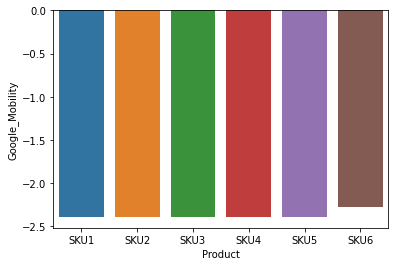

In [ ]:
gp = pd.DataFrame(df.groupby(["Product"])["Google_Mobility"].mean())
sns.barplot(data=gp,x=dp.index,y='Google_Mobility')
plt.show()

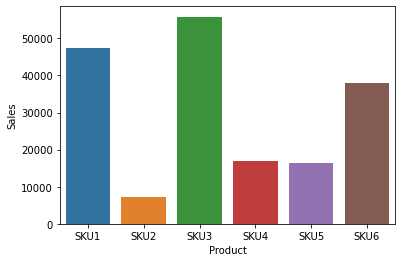

In [ ]:
spd = pd.DataFrame(df.groupby(["Product","day_week"])["Sales"].mean())
spd1 = spd.reset_index()
sns.barplot(data=spd1,x='Product',y='Sales')
plt.show()

In [ ]:
spm = pd.DataFrame(df.groupby(["Product","month"])["Sales"].sum().sort_values(ascending=False))
spm1 = spm.reset_index()
spm1['max Sales']=spm1.groupby(['Product'])['Sales'].transform(max)
spm1 = spm1[spm1['Sales'] == spm1['max Sales']].reset_index(drop=True)

spm1

,Product,month,Sales,max Sales
0,SKU1,12,1623843,1623843
1,SKU6,10,1566017,1566017
2,SKU3,6,1474162,1474162
3,SKU5,7,453604,453604
4,SKU4,8,424170,424170
5,SKU2,10,222904,222904


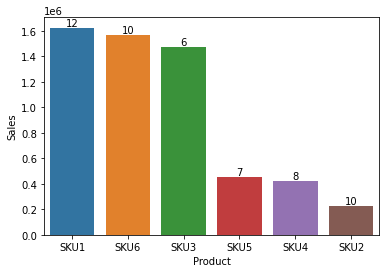

In [ ]:
for i in range(len(spm1)):
    word = spm1.loc[i, "month"]
    y = spm1.loc[i, "Sales"]
    plt.annotate(word, (i, y), ha="center", va="bottom")

sns.barplot(data=spm1,x='Product',y='Sales')
plt.show()

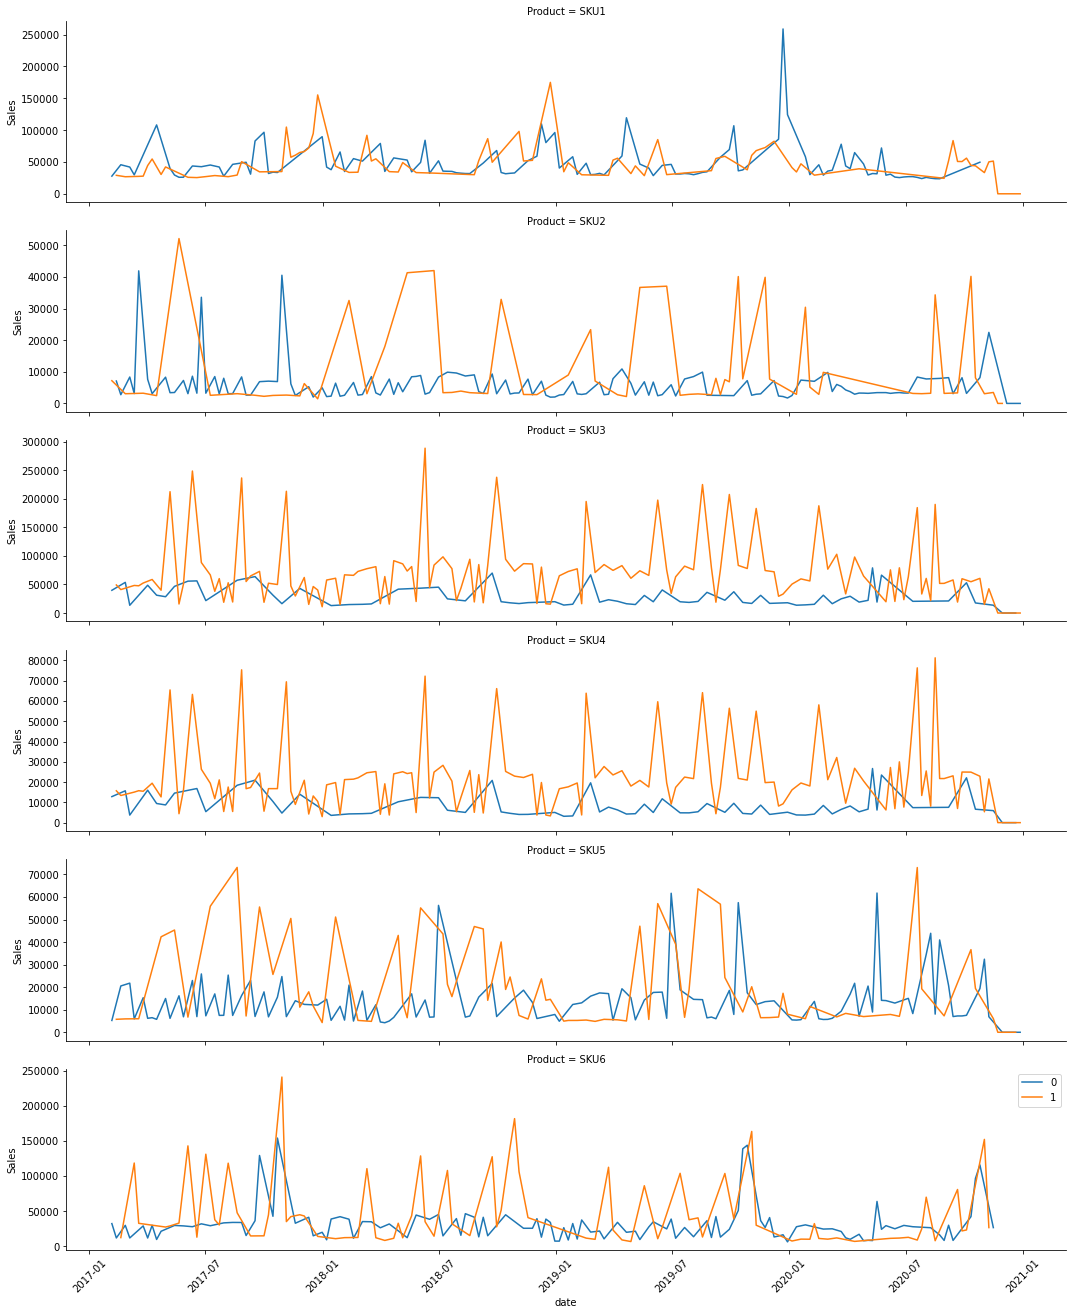

In [ ]:
g = sns.FacetGrid(df,hue="In-Store Promo",row="Product",aspect=5, sharey=False)
g.map(sns.lineplot,"date","Sales")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

**According to EDA, our group made the following recommendations:**

1) At product level, it is evident that SKU1, SKU3, and SKU6 are the top three products that generate major sales amount for the company. So we will recommend the company should put their main sources to produce those three products.

2) Via plotting out the sales by each product and by year, the pattern seems overlapping. Peaks appear mainly in the summer times. And for SKU1, it has its uniqe seasonal pattern. The peak happened majorly at the end of a year. By further exploration, SKU1 has less degree of discount than the others. Thus, for customers, the demand is relatively inelastic. For SKU1, we recommend there should be no discount from February to December and a small discount percentage in January.

3) For SKU3, we shall see that March is the month when the sales is the highest. Also, SKU3 has a relatively large range of discount. Therefore, for SKU3, the company can put heavier discount on SKU3 product in March. SKU6 can have the same strategy as they show similar charateristics.

## Forecasting Models

### Simple Naive

In [ ]:
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,month,day_week,discount
0,SKU1,2017-02-05,27750,0%,0,0,0,0.0,0,0,0,0,2,7,0.00
1,SKU1,2017-02-12,29023,0%,1,0,1,0.0,0,1,0,0,2,7,0.00
2,SKU1,2017-02-19,45630,17%,0,0,0,0.0,0,0,0,0,2,7,0.17
3,SKU1,2017-02-26,26789,0%,1,0,1,0.0,0,0,0,0,2,7,0.00
4,SKU1,2017-03-05,41999,17%,0,0,0,0.0,0,0,0,0,3,7,0.17


In [ ]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

In [ ]:
df1 = df1[df1['Sales'] != 0]
df2 = df2[df2['Sales'] != 0]
df3 = df3[df3['Sales'] != 0]

In [ ]:
# remove outliers by 90% cap
ninetieth_percentile = np.percentile(df1["Sales"], 90)
df1.loc[df["Sales"] >= ninetieth_percentile, "Sales"] = ninetieth_percentile

In [ ]:
# normalization
def normalize(column):
    up = column.max()
    lo = column.min()
    y = (column - lo)/(up-lo)
    return y

df2['Sales'] = normalize(df2['Sales'])

In [ ]:
# taking log
df3['Sales'] = [np.log(x) for x in df3['Sales']]

In [ ]:
sku1 = df1[df1['Product'] == 'SKU1']
sku2 = df1[df1['Product'] == 'SKU2']
sku3 = df1[df1['Product'] == 'SKU3']
sku4 = df1[df1['Product'] == 'SKU4']
sku5 = df1[df1['Product'] == 'SKU5']
sku6 = df1[df1['Product'] == 'SKU6']

sku12 = df2[df2['Product'] == 'SKU1']
sku22 = df2[df2['Product'] == 'SKU2']
sku32 = df2[df2['Product'] == 'SKU3']
sku42 = df2[df2['Product'] == 'SKU4']
sku52 = df2[df2['Product'] == 'SKU5']
sku62 = df2[df2['Product'] == 'SKU6']

sku13 = df3[df3['Product'] == 'SKU1']
sku23 = df3[df3['Product'] == 'SKU2']
sku33 = df3[df3['Product'] == 'SKU3']
sku43 = df3[df3['Product'] == 'SKU4']
sku53 = df3[df3['Product'] == 'SKU5']
sku63 = df3[df3['Product'] == 'SKU6']

In [ ]:
def naive(df):
    train_len = round(len(df) * 0.8)
    train = df[0:train_len] 
    test = df[train_len:]
    
    y_hat_naive = test.copy()
    y_hat_naive['naive_forecast'] = train['Sales'].iloc[train_len-1]
       
    mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales']),2)
    accuracy = 1 - mape
    
    return accuracy

In [ ]:
def best_accuracy(data1,data2,data3):
    l = list([naive(data1), naive(data2),naive(data3)])
    accuracy = max(l)
    
    d = pd.DataFrame()
    if accuracy == l[0]:
        d = data1.copy()
        method = '90% Cap'
    elif accuracy == l[1]:
        d = data2.copy()
        method = 'Normalization'
    else:
        d = data3.copy()
        method = 'Log Transformation'
    
    
    train_len = round(len(d) * 0.8)
    train = d[0:train_len] 
    test = d[train_len:]
    
    y_hat_naive = test.copy()
    y_hat_naive['naive_forecast'] = train['Sales'].iloc[train_len-1]
    
    plt.figure(figsize = (20,5))
    plt.grid()
    sns.lineplot(x="date",y="Sales",data=train,label='Train')
    sns.lineplot(x="date",y="Sales",data=test,label='Test')
    sns.lineplot(x="date",y="naive_forecast",data=y_hat_naive,label='Naive forecast')
    plt.xticks(rotation=45)
    
    rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_naive['naive_forecast'])).round(2)
    mape = 1 - accuracy
    results = pd.DataFrame({'Method':['Naive method' + ' ' + method], 'MAPE': [mape], 'RMSE': [rmse],'Accuracy':[accuracy]})
    results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
    results
    
    return results

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.44,0.03,0.97


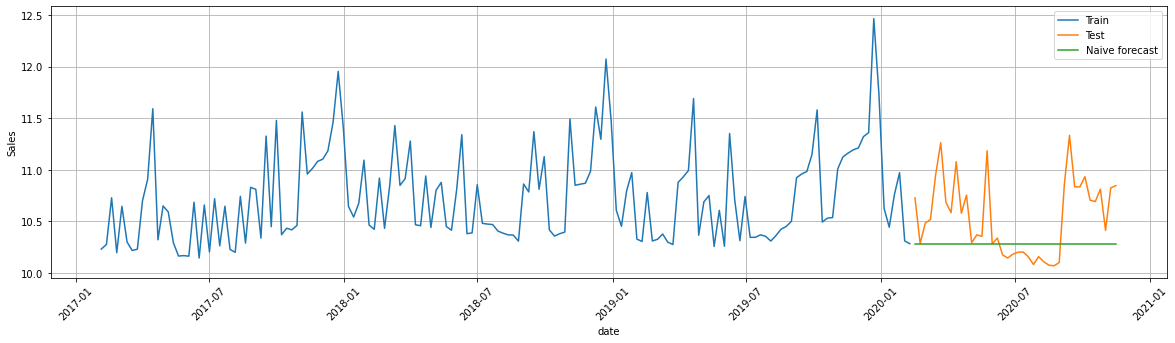

In [ ]:
best_accuracy(sku1,sku12,sku13)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.75,0.08,0.92


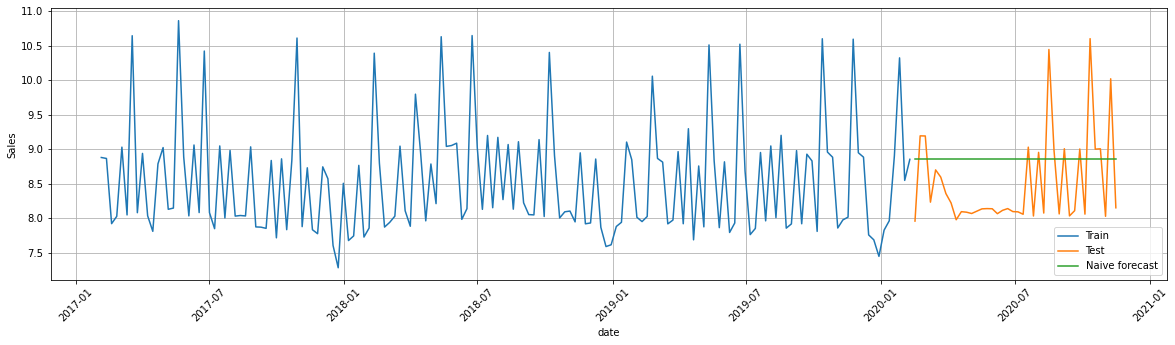

In [ ]:
best_accuracy(sku2,sku22,sku23)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,1.23,0.09,0.91


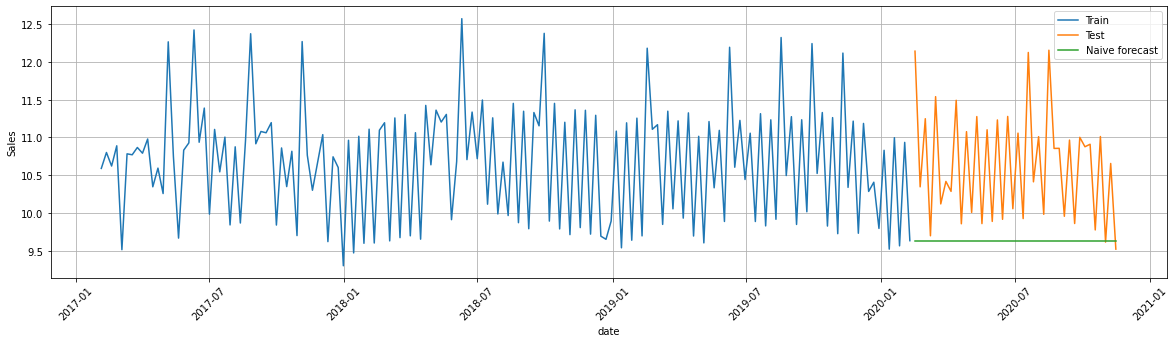

In [ ]:
best_accuracy(sku3,sku32,sku33)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,1.46,0.12,0.88


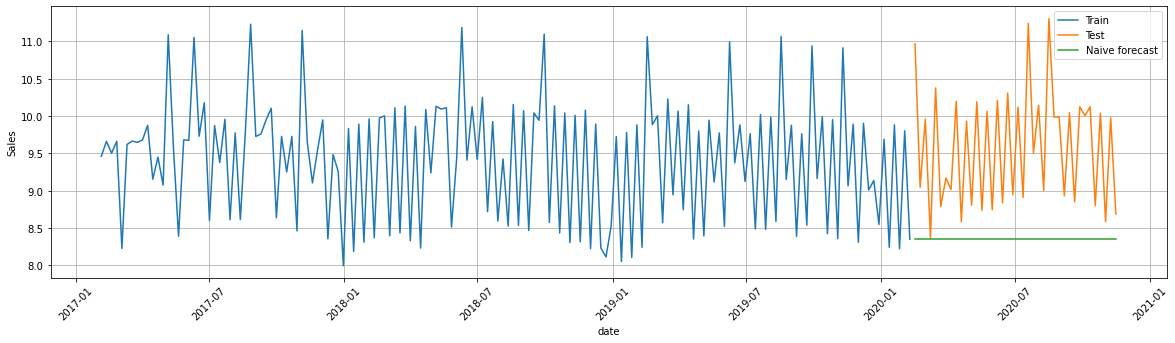

In [ ]:
best_accuracy(sku4,sku42,sku43)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.71,0.06,0.94


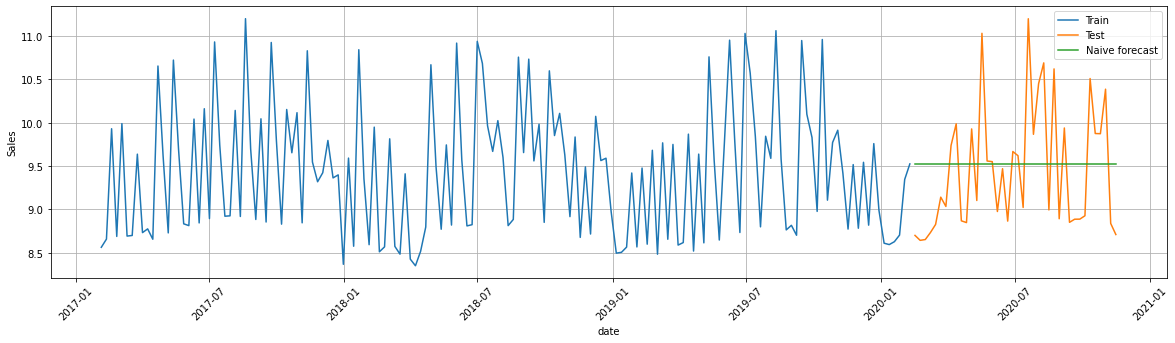

In [ ]:
best_accuracy(sku5,sku52,sku53)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.92,0.08,0.92


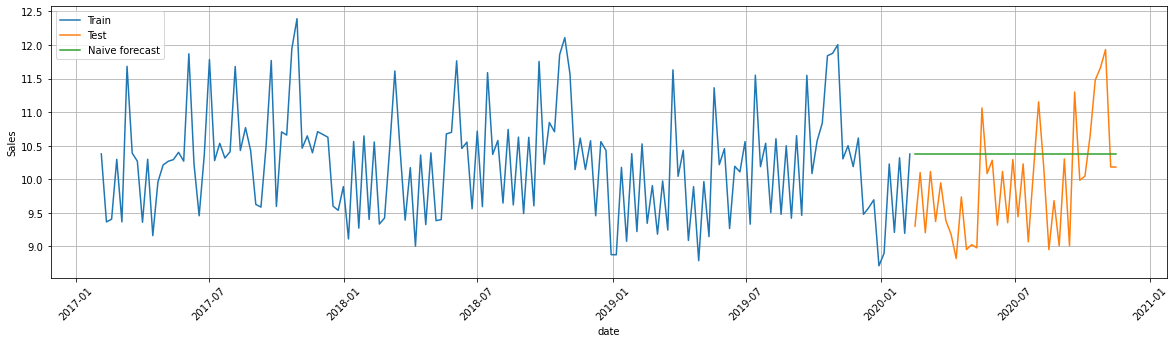

In [ ]:
best_accuracy(sku6,sku62,sku63)

### Holt-Winter's Seasonal Method

In [ ]:
def holtws(df,period):
    train_len = round(len(df) * 0.8)
    train = df[0:train_len].reset_index(drop=True)
    test = df[train_len:].reset_index(drop=True)
    test.index = pd.RangeIndex(start=train_len, stop=len(df), step=1)
    
    rmse = []
    
    fit1 = ExponentialSmoothing(train[train['Sales'] > 0]['Sales'],seasonal_periods = period, trend='add', seasonal='add').fit()
    fcast1 = fit1.forecast(len(test)).rename('Additive')
    rmse1 = np.sqrt(mean_squared_error(test['Sales'], fcast1)).round(2)
    mape1 = np.round(np.mean(np.abs(test['Sales']-fcast1)/test['Sales']),2)
        
    fit2 = ExponentialSmoothing(train[train['Sales'] > 0]['Sales'], seasonal_periods = period, trend='add', seasonal='add', damped=True).fit()
    fcast2 = fit2.forecast(len(test)).rename('Additive+damped')
    rmse2 = np.sqrt(mean_squared_error(test['Sales'], fcast2)).round(2)
    mape2 = np.round(np.mean(np.abs(test['Sales']-fcast2)/test['Sales']),2)
    
    fit3 = ExponentialSmoothing(train[train['Sales'] > 0]['Sales'], seasonal_periods = period, trend='add', seasonal='mul').fit()
    fcast3 = fit3.forecast(len(test)).rename('Multiplicative')
    rmse3 = np.sqrt(mean_squared_error(test['Sales'], fcast3)).round(2)
    mape3 = np.round(np.mean(np.abs(test['Sales']-fcast3)/test['Sales']),2)
        
    fit4 = ExponentialSmoothing(train[train['Sales'] > 0]['Sales'], seasonal_periods = 52, trend='add', seasonal='mul', damped=True).fit()
    fcast4 = fit4.forecast(len(test)).rename('Multiplicative+damped')
    rmse4 = np.sqrt(mean_squared_error(test['Sales'], fcast4)).round(2)
    mape4 = np.round(np.mean(np.abs(test['Sales']-fcast4)/test['Sales']),2) 
    
    accuracy1 = 1 - mape1
    accuracy2 = 1 - mape2
    accuracy3 = 1 - mape3
    accuracy4 = 1 - mape4
    
    l = list([accuracy1, accuracy2, accuracy3, accuracy4])
    accuracy = max(l)
    
    if accuracy == l[0]:
        method = 'Additive'
    elif accuracy == l[1]:
        method = 'Additive+Damped'
    elif accuracy == l[2]:
        method = 'Multiplicative'
    else:
        method = 'Multiplicative+Damped'

        
    return method,round(accuracy,2)

In [ ]:
def best_accuracy_holt(data1,data2,data3,period):
    d = pd.DataFrame([holtws(data1,period),holtws(data2,period),holtws(data3,period)],columns=['Method','Value'])
    accuracy = max(d['Value'])
    idx = d['Value'].idxmax()
    method1 = d.loc[idx,'Method']
    
    dd = pd.DataFrame()
    if idx == 0:
        dd = data1.copy()
        method2 = '90% Cap'
    elif idx == 1:
        dd = data2.copy()
        method2 = 'Normalization'
    else:
        dd = data3.copy()
        method2 = 'Log Transformation'
    
    s = ''
    da = True
    if method1 == 'Additive':
        s = 'add'
        da = False
    elif method1 == "Additive+Damped":
        s = 'add'
        da = True
    elif method1 == 'Multiplicative':
        s = 'mul'
        da = False
    else:
        s = 'mul'
        da = True
    
    train_len = round(len(dd) * 0.8)
    train = dd[0:train_len].reset_index(drop=True)
    test = dd[train_len:].reset_index(drop=True)
    test.index = pd.RangeIndex(start=train_len, stop=len(dd), step=1)
    
    
    fit = ExponentialSmoothing(train['Sales'], seasonal_periods = period, trend='add', seasonal=s, damped=da).fit()
    fcast = fit.forecast(len(test)).rename('Additive+damped')
    rmse = np.sqrt(mean_squared_error(test['Sales'], fcast)).round(2)
    mape = np.round(np.mean(np.abs(test['Sales']-fcast)/test['Sales']),2)
    
    results = pd.DataFrame({'Method':[method1 + '_'+method2], 'MAPE': [mape], 
                                'RMSE': [rmse],'Accuracy':[accuracy]})
    results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
    
    plt.figure(figsize = (20,5))
    plt.grid()
    fcast.plot(style='--', marker='o', color='black', legend=True)
    test['Sales'].plot(style='--',color='green',legend=True) 
    plt.show()
    
    return results

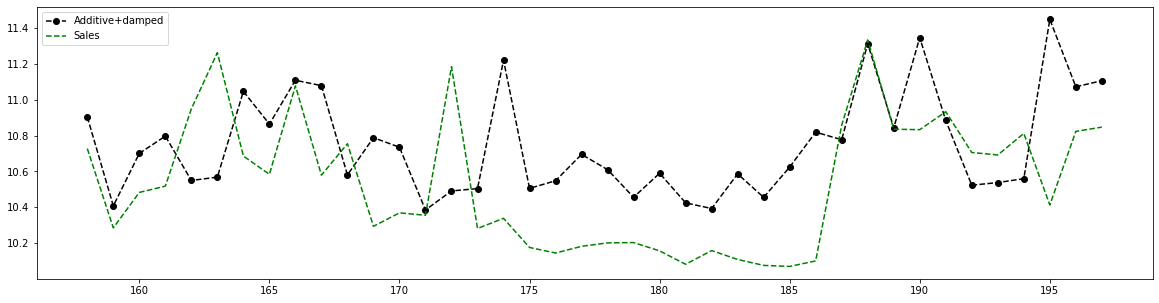

,Method,RMSE,MAPE,Accuracy
0,Additive_Log Transformation,0.42,0.03,0.97


In [ ]:
best_accuracy_holt(sku1,sku12,sku13,52)

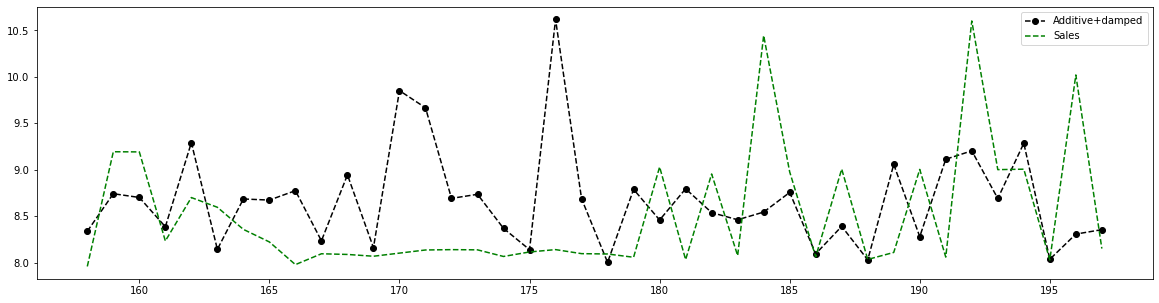

,Method,RMSE,MAPE,Accuracy
0,Additive_Log Transformation,0.85,0.07,0.93


In [ ]:
best_accuracy_holt(sku2,sku22,sku23,52)

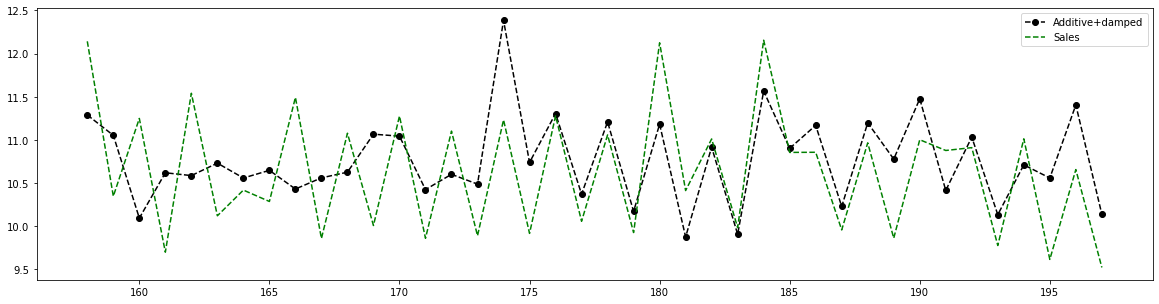

,Method,RMSE,MAPE,Accuracy
0,Additive_Log Transformation,0.63,0.05,0.95


In [ ]:
best_accuracy_holt(sku3,sku32,sku33,52)

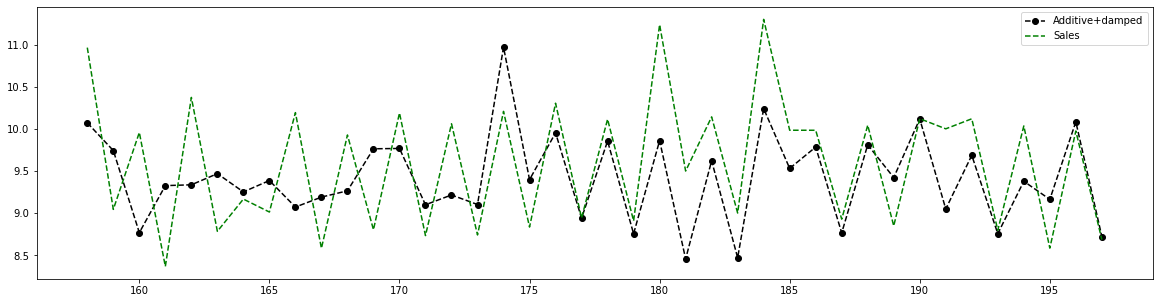

,Method,RMSE,MAPE,Accuracy
0,Additive_Log Transformation,0.67,0.06,0.94


In [ ]:
best_accuracy_holt(sku4,sku42,sku43,52)

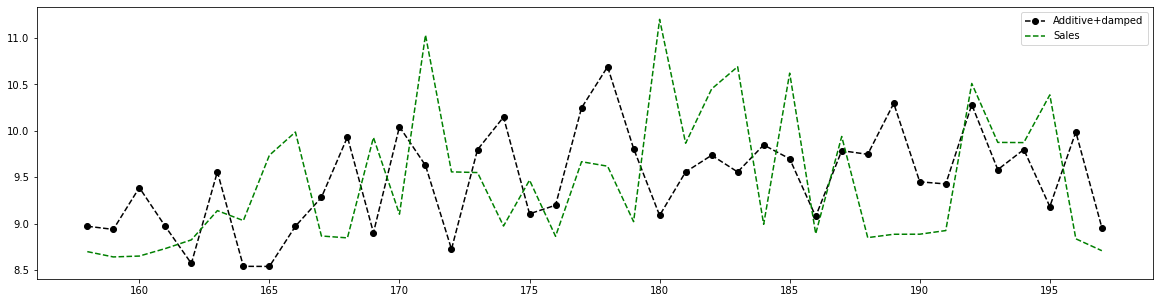

,Method,RMSE,MAPE,Accuracy
0,Additive_Log Transformation,0.83,0.07,0.93


In [ ]:
best_accuracy_holt(sku5,sku52,sku53,52)

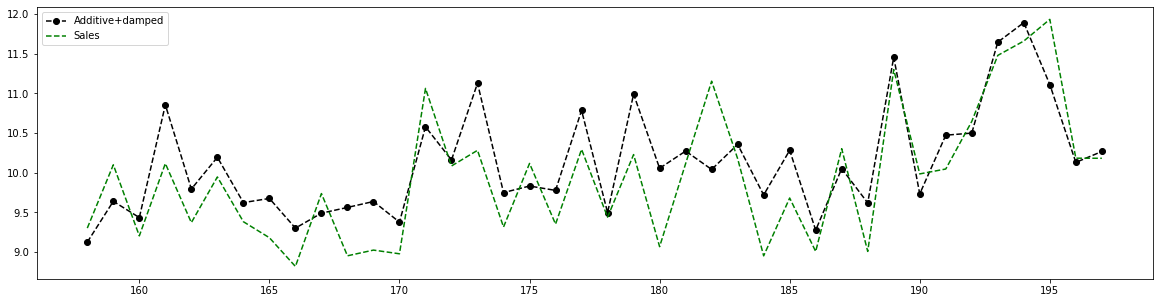

,Method,RMSE,MAPE,Accuracy
0,Additive_Log Transformation,0.49,0.04,0.96


In [ ]:
best_accuracy_holt(sku6,sku62,sku63,52)

### SARIMA

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
def sarima(df):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],4) for x in list(itertools.product(p, d, q))]
    
    train_len = round(len(df) * 0.8)
    train = df[0:train_len].reset_index(drop=True)
    test = df[train_len:].reset_index(drop=True)
    test.index = pd.RangeIndex(start=train_len, stop=len(df), step=1)
    
    param_mini = []
    param_seasonal_mini = []
    mini = float('+inf')

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(train['Sales'],
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                
                results = mod.fit(disp=0)
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    
    mod1 = SARIMAX(train['Sales'],
              order=param_mini,
              seasonal_order=param_seasonal_mini,
              enforce_stationarity=False,
              enforce_invertibility=False)

    results1 = mod1.fit(disp=0)
    
    fcast = results1.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test['Sales'], fcast)).round(2)
    mape = np.round(np.mean(np.abs(test['Sales']-fcast)/test['Sales']),2)
    accuracy = 1 - mape
    
    res = [rmse,mape,round(accuracy,2), param_mini, param_seasonal_mini]
    
    return res

In [ ]:
def best_accuracy_arima(data1,data2,data3):
    d = pd.DataFrame([sarima(data1),sarima(data2),sarima(data3)],columns=['rmse','mape','accuracy','order','s_order'])
    accuracy = max(d['accuracy'])
    idx = d['accuracy'].idxmax()
    o = d.loc[d['accuracy'].idxmax(),'order']
    so = d.loc[d['accuracy'].idxmax(),'s_order']
    
    dd = pd.DataFrame()
    if idx == 0:
        dd = data1.copy()
        method = '90% Cap'
    elif idx == 1:
        dd = data2.copy()
        method = 'Normalization'
    else:
        dd = data3.copy()
        method = 'Log Transformation'
    
    
    train_len = round(len(dd) * 0.8)
    train = dd[0:train_len].reset_index(drop=True)
    test = dd[train_len:].reset_index(drop=True)
    test.index = pd.RangeIndex(start=train_len, stop=len(dd), step=1)
    
    mod1 = SARIMAX(train['Sales'],
              order=o,
              seasonal_order=so,
              enforce_stationarity=False,
              enforce_invertibility=False)

    results1 = mod1.fit(disp=0)
    
    fcast = results1.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test['Sales'], fcast)).round(2)
    mape = np.round(np.mean(np.abs(test['Sales']-fcast)/test['Sales']),2)
    accuracy = 1 - mape
    
    plt.figure(figsize = (20,5))
    plt.grid()
    fcast.plot(style='--', marker='o', color='black', legend=True)
    test['Sales'].plot(style='--',color='green',legend=True) 
    plt.show()
    
    final = pd.DataFrame({'Method':[method], 'MAPE': [mape], 
                                'RMSE': [rmse],'Accuracy':[accuracy],
                                'Order':[o],'Seasonal_order':[so]})
    final = final[['Method', 'RMSE', 'MAPE','Accuracy','Order','Seasonal_order']]
    
    return final

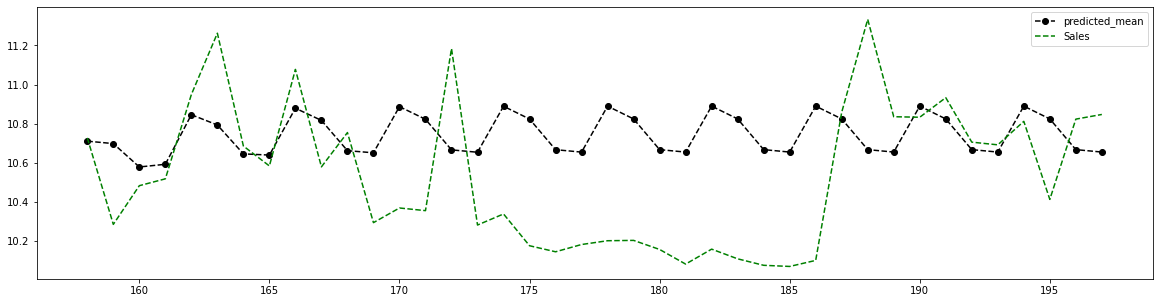

,Method,RMSE,MAPE,Accuracy,Order,Seasonal_order
0,Log Transformation,0.43,0.03,0.97,"(1, 0, 1)","(0, 1, 1, 4)"


In [ ]:
best_accuracy_arima(sku1,sku12,sku13)

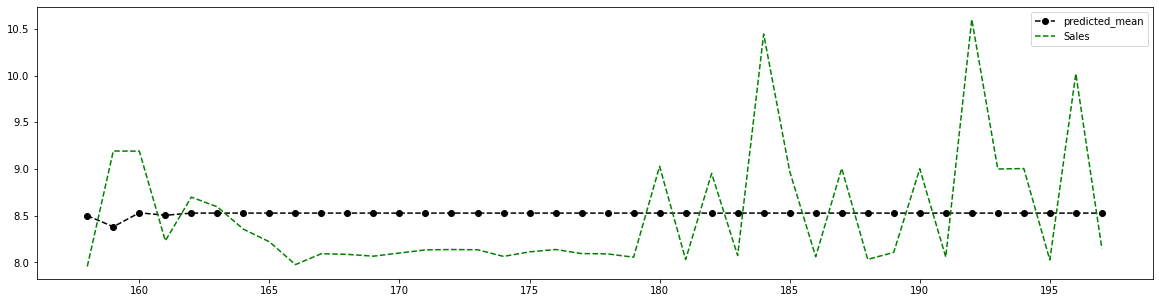

,Method,RMSE,MAPE,Accuracy,Order,Seasonal_order
0,Log Transformation,0.67,0.06,0.94,"(0, 1, 1)","(0, 0, 1, 4)"


In [ ]:
best_accuracy_arima(sku2,sku22,sku23)

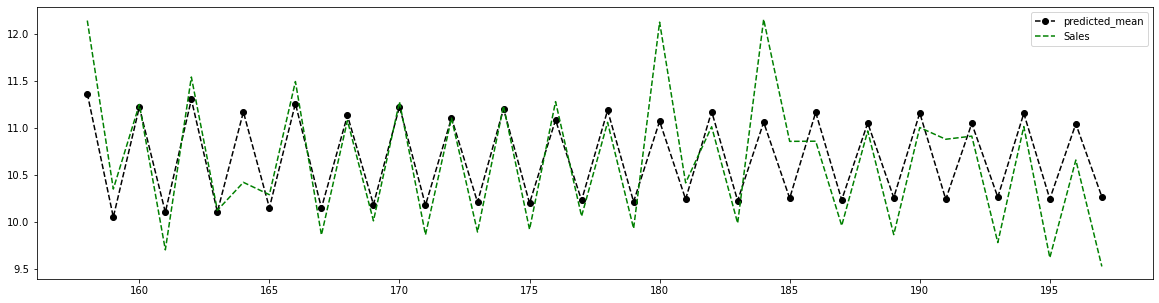

,Method,RMSE,MAPE,Accuracy,Order,Seasonal_order
0,Log Transformation,0.42,0.03,0.97,"(1, 0, 1)","(0, 1, 1, 4)"


In [ ]:
best_accuracy_arima(sku3,sku32,sku33)

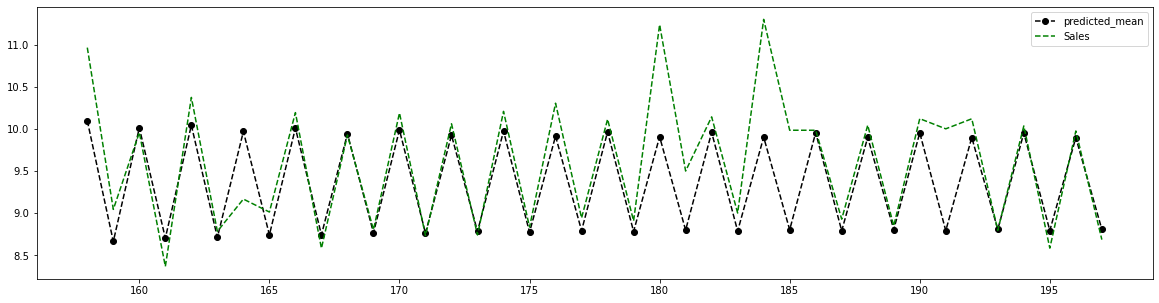

,Method,RMSE,MAPE,Accuracy,Order,Seasonal_order
0,Log Transformation,0.49,0.03,0.97,"(1, 0, 1)","(0, 1, 1, 4)"


In [ ]:
best_accuracy_arima(sku4,sku42,sku43)

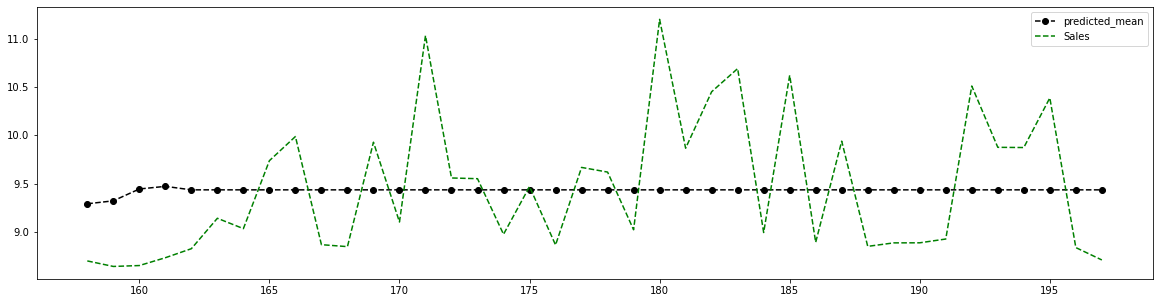

,Method,RMSE,MAPE,Accuracy,Order,Seasonal_order
0,Log Transformation,0.71,0.06,0.94,"(0, 1, 1)","(0, 0, 1, 4)"


In [ ]:
best_accuracy_arima(sku5,sku52,sku53)

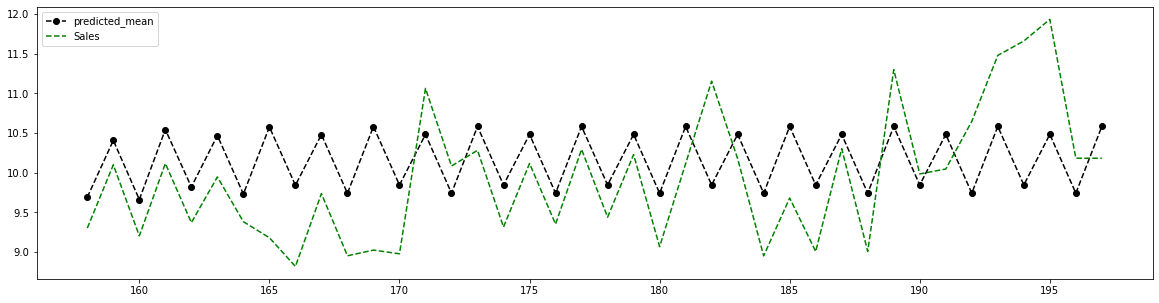

,Method,RMSE,MAPE,Accuracy,Order,Seasonal_order
0,Log Transformation,0.76,0.07,0.93,"(1, 0, 1)","(1, 1, 1, 4)"


In [ ]:
best_accuracy_arima(sku6,sku62,sku63)

### Linear Regression

In [ ]:
df= pd.read_csv('forecasting_case_study.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1218 non-null   object 
 1   date                1218 non-null   object 
 2   Sales               1218 non-null   int64  
 3   Price Discount (%)  1218 non-null   object 
 4   In-Store Promo      1218 non-null   int64  
 5   Catalogue Promo     1218 non-null   int64  
 6   Store End Promo     1218 non-null   int64  
 7   Google_Mobility     1218 non-null   float64
 8   Covid_Flag          1218 non-null   int64  
 9   V_DAY               1218 non-null   int64  
 10  EASTER              1218 non-null   int64  
 11  CHRISTMAS           1218 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 114.3+ KB


In [ ]:
df = df[df['Sales'] != 0]
df.reset_index(drop=True, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
df['date']=df['date'] - df['date'].min() + 1

df['Price Discount (%)'] = df['Price Discount (%)'].str.replace('%', '').astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1188 non-null   object 
 1   date                1188 non-null   int64  
 2   Sales               1188 non-null   int64  
 3   Price Discount (%)  1188 non-null   float64
 4   In-Store Promo      1188 non-null   int64  
 5   Catalogue Promo     1188 non-null   int64  
 6   Store End Promo     1188 non-null   int64  
 7   Google_Mobility     1188 non-null   float64
 8   Covid_Flag          1188 non-null   int64  
 9   V_DAY               1188 non-null   int64  
 10  EASTER              1188 non-null   int64  
 11  CHRISTMAS           1188 non-null   int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 111.5+ KB


In [ ]:
products = df['Product'].unique()

#create a data frame dictionary to store your data frames for different products
DataFrameDict = {elem : pd.DataFrame() for elem in products}

for key in DataFrameDict.keys():
    df_temp = df[:][df['Product'] == key]
    DataFrameDict[key] = df_temp.drop(['Product'], axis=1)
    
# print(DataFrameDict)

In [ ]:
drop_enc = LabelBinarizer()
drop_enc.fit(df['Product'])
encoded = drop_enc.transform(df['Product'])
df.drop("Product", axis=1, inplace=True)
ohe_df = pd.DataFrame(encoded, columns=['SKU1','SKU2','SKU3','SKU4','SKU5','SKU6'])
df = pd.concat([df, ohe_df], axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

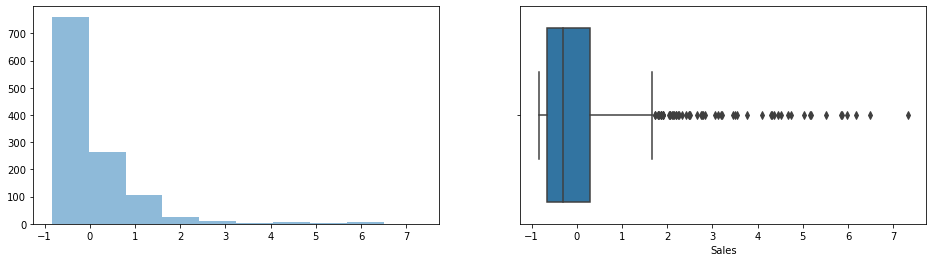

In [ ]:
# normalize sales
y = df['Sales']
y_mean = y.mean()
y_std = y.std()
y_normalized = (y-y_mean)/y_std
plt.figure(figsize=(16,4))
#Histogram
plt.subplot(1,2,1)
plt.hist(y_normalized, alpha=0.5)
#boxplot
plt.subplot(1,2,2)
sns.boxplot(y_normalized, orient="h")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

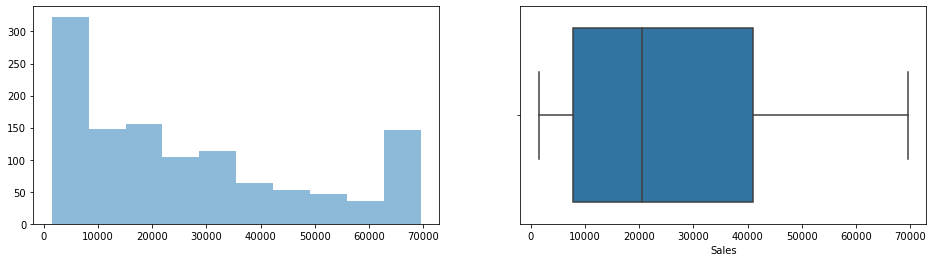

In [ ]:
# 90% cap sales
ninetieth_percentile = np.percentile(y, 90)
y_capping = y
y_capping[y_capping > ninetieth_percentile] = ninetieth_percentile
plt.figure(figsize=(16,4))
#Histogram
plt.subplot(1,2,1)
plt.hist(y_capping, alpha=0.5)
#boxplot
plt.subplot(1,2,2)
sns.boxplot(y_capping, orient="h")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

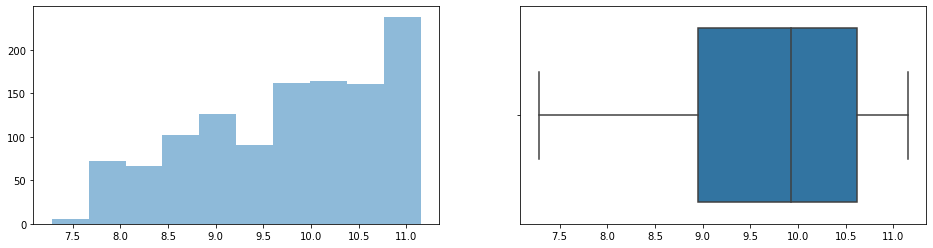

In [ ]:
# log transform sales
y_log = [np.log(x) for x in df['Sales']]
plt.figure(figsize=(16,4))
#Histogram
plt.subplot(1,2,1)
plt.hist(y_log, alpha=0.5)
#boxplot
plt.subplot(1,2,2)
sns.boxplot(y_log, orient="h")
plt.show

In [ ]:
X = df[['date', 'Price Discount (%)', 'In-Store Promo', 'Catalogue Promo', 'Store End Promo', 'Google_Mobility', 'Covid_Flag', 'V_DAY', 'EASTER', 'CHRISTMAS', 'SKU1','SKU2','SKU3','SKU4','SKU5','SKU6']]
df.info()
# print(df.iloc[pd.isnull(df).any(1).to_numpy().nonzero()])

model = linear_model.LinearRegression()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1188 non-null   int64  
 1   Sales               1188 non-null   float64
 2   Price Discount (%)  1188 non-null   float64
 3   In-Store Promo      1188 non-null   int64  
 4   Catalogue Promo     1188 non-null   int64  
 5   Store End Promo     1188 non-null   int64  
 6   Google_Mobility     1188 non-null   float64
 7   Covid_Flag          1188 non-null   int64  
 8   V_DAY               1188 non-null   int64  
 9   EASTER              1188 non-null   int64  
 10  CHRISTMAS           1188 non-null   int64  
 11  SKU1                1188 non-null   int64  
 12  SKU2                1188 non-null   int64  
 13  SKU3                1188 non-null   int64  
 14  SKU4                1188 non-null   int64  
 15  SKU5                1188 non-null   int64  
 16  SKU6  

In [ ]:
for product in products:
    df = DataFrameDict[product]
    X = df.drop(columns=['Sales'])
    y = df[['Sales']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"The MAPE accuracy of {product} is: {1 - mean_absolute_percentage_error(y_test, y_pred)}")

The MAPE accuracy of SKU1 is: 0.8398777249774831
The MAPE accuracy of SKU2 is: 0.3804485261137739
The MAPE accuracy of SKU3 is: 0.4540392195108115
The MAPE accuracy of SKU4 is: 0.30662674140571045
The MAPE accuracy of SKU5 is: 0.47227410516374546
The MAPE accuracy of SKU6 is: -0.18838598683650787


### RNN

In [ ]:
import torch
import torch.nn as nn
from torchmetrics.functional import accuracy
import torchmetrics
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [ ]:
df= pd.read_csv('forecasting_case_study.csv')
df = df[df['Sales'] != 0]
df.reset_index(drop=True, inplace=True)
df['Price Discount (%)'] = df['Price Discount (%)'].str.replace('%', '').astype(float)
df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
df['date']=df['date'] - df['date'].min() + 1
print(df.info())

products = df['Product'].unique()

#create a data frame dictionary to store your data frames for different products
DataFrameDict = {elem : pd.DataFrame() for elem in products}

for key in DataFrameDict.keys():
    df_temp = df[:][df['Product'] == key]
    DataFrameDict[key] = df_temp.drop(['Product'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1188 non-null   object 
 1   date                1188 non-null   int64  
 2   Sales               1188 non-null   int64  
 3   Price Discount (%)  1188 non-null   float64
 4   In-Store Promo      1188 non-null   int64  
 5   Catalogue Promo     1188 non-null   int64  
 6   Store End Promo     1188 non-null   int64  
 7   Google_Mobility     1188 non-null   float64
 8   Covid_Flag          1188 non-null   int64  
 9   V_DAY               1188 non-null   int64  
 10  EASTER              1188 non-null   int64  
 11  CHRISTMAS           1188 non-null   int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 111.5+ KB
None


In [ ]:
drop_enc = LabelBinarizer()
drop_enc.fit(df['Product'])
encoded = drop_enc.transform(df['Product'])
df.drop("Product", axis=1, inplace=True)
ohe_df = pd.DataFrame(encoded, columns=['SKU1','SKU2','SKU3','SKU4','SKU5','SKU6'])
df = pd.concat([df, ohe_df], axis=1)


df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
df['date']=df['date'] - df['date'].min() + 1
df = df.set_index(['date'])
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
    
# 90% cap sales
# y = df['Sales']
# ninetieth_percentile = np.percentile(y, 90)
# df.loc[df['Sales'] > ninetieth_percentile] = ninetieth_percentile

# y = df['Sales']
# y_mean = y.mean()
# y_std = y.std()
# y_normalized = (y-y_mean)/y_std
# df['Sales'] = y_normalized

df['Sales'] = [np.log(x) for x in df['Sales']]

# plt.figure(figsize=(16,4))
# #Histogram
# plt.subplot(1,2,1)
# plt.hist(y_capping, alpha=0.5)
# #boxplot
# plt.subplot(1,2,2)
# sns.boxplot(y_capping, orient="h")
# plt.show

print(df.head())

          Sales  Price Discount (%)  In-Store Promo  Catalogue Promo  \
date                                                                   
1     10.230991                 0.0               0                0   
1     10.275844                 0.0               1                0   
1     10.728321                17.0               0                0   
1     10.195747                 0.0               1                0   
1     10.645401                17.0               0                0   

      Store End Promo  Google_Mobility  Covid_Flag  V_DAY  EASTER  CHRISTMAS  \
date                                                                           
1                   0              0.0           0      0       0          0   
1                   1              0.0           0      1       0          0   
1                   0              0.0           0      0       0          0   
1                   1              0.0           0      0       0          0   
1              

In [ ]:
def split_data(df, train_size=0.8, val_size=0.2, test_size=0.2, shuffle=True, drop_last=True):
    X = df.drop(columns=['Sales'])
    y = df[['Sales']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # val split?
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)

    # scaler?
    scaler = MinMaxScaler()
    X_train_arr = scaler.fit_transform(X_train)
    X_val_arr = scaler.transform(X_val)
    X_test_arr = scaler.transform(X_test)

    y_train_arr = scaler.fit_transform(y_train)
    y_val_arr = scaler.transform(y_val)
    y_test_arr = scaler.transform(y_test)

    # data loader
    train_features = torch.Tensor(X_train_arr)
    train_targets = torch.Tensor(y_train_arr)
    val_features = torch.Tensor(X_val_arr)
    val_targets = torch.Tensor(y_val_arr)
    test_features = torch.Tensor(X_test_arr)
    test_targets = torch.Tensor(y_test_arr)

    train = TensorDataset(train_features, train_targets)
    val = TensorDataset(val_features, val_targets)
    test = TensorDataset(test_features, test_targets)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    
    return train_loader, val_loader, test_loader

In [ ]:
class MyGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size=64, dropout_prob=0.5):
        super(MyGRU, self).__init__()
        self.last_hidden = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, hidden = self.gru(x, self.last_hidden)
        output = output[:, -1] # TODO: [:, -1, :]?
        self.last_hidden = hidden.data # TODO: .data?
        #print(self.last_hidden.shape)
        
        return self.fc(output)

class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size=64, dropout_prob=0.5):
        super(MyLSTM, self).__init__()
        self.last_hidden = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.last_cell = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x, (self.last_hidden, self.last_cell))
        output = output[:, -1] # TODO: [:, -1, :]?
        self.last_hidden = hidden.data # TODO: .data?
        self.last_cell = cell.data
        #print(self.last_hidden.shape)
        
        return self.fc(output)
    
class MyRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size=64, dropout_prob=0.5):
        super(MyRNN, self).__init__()
        self.last_hidden = torch.zeros(num_layers, batch_size, hidden_dim).to(device)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, hidden = self.rnn(x, self.last_hidden)
        output = output[:, -1] # TODO: [:, -1, :]?
        self.last_hidden = hidden.data # TODO: .data?
        #print(self.last_hidden.shape)
        
        return self.fc(output)
    
def get_model(model, model_params):
    models = {
        "rnn": MyRNN,
        "lstm": MyLSTM,
        "gru": MyGRU,
    }
    return models.get(model.lower())(**model_params)

In [ ]:

class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()
    
    
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
    
    
    def evaluate(self, test_loader, n_features, batch_size=64):

        with torch.no_grad():
            predictions = []
            values = []
            
            for x_test, y_test in test_loader:
                #print(next(iter(test_loader.dataset)))
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values
    
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()


In [ ]:
def train_model(model_name, df, model_params, input_dim, batch_size=64, n_epochs=100):
    train_loader, val_loader, test_loader = split_data(df)
    # print(next(iter(val_loader.dataset)))
    # print(next(iter(test_loader.dataset)))
    model = get_model(model_name, model_params)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = nn.MSELoss(reduction="mean")
    
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
    opt.plot_losses()

    predictions, values = opt.evaluate(test_loader, n_features=input_dim, batch_size=batch_size)
    accuracy = 1 - mean_absolute_percentage_error(values[0], predictions[0])
    print(f"The MAPE value of {model_name} is {accuracy}.\n")

def main():
    output_dim = 1
    hidden_dim = 64
    num_layers = 3
    batch_size = 64
    dropout = 0.2
    n_epochs = 100
    input_dim_all = len(df.columns)-1
    model_params_all = {'input_dim': input_dim_all,
                    'hidden_dim' : hidden_dim,
                    'num_layers' : num_layers,
                    'output_dim' : output_dim,
                    'batch_size' : batch_size,
                    'dropout_prob' : dropout}
    
    input_dim_product = len(DataFrameDict['SKU1'].columns)-1
    model_params_product = {'input_dim': input_dim_product,
                    'hidden_dim' : hidden_dim,
                    'num_layers' : num_layers,
                    'output_dim' : output_dim,
                    'batch_size' : batch_size,
                    'dropout_prob' : dropout}
    
    
    print("Now training RNN with one-hot encoded product types...")
    train_model('RNN', df, model_params_all, input_dim_all, batch_size=batch_size, n_epochs=n_epochs)
    
    # print("Now training RNN with product types separated...")
    # for product in products:
    #     print(f"{product}:\n")
    #     train_model('RNN', DataFrameDict[product], model_params_product, input_dim_product, batch_size=batch_size, n_epochs=n_epochs)
    
    print("Now training LSTM...")
    train_model('LSTM', df, model_params_all, input_dim_all, batch_size=batch_size, n_epochs=n_epochs)
    
    # print("Now training LSTM with product types separated...")
    # for product in products:
    #     print(f"{product}:\n")
    #     train_model('LSTM', DataFrameDict[product], model_params_product, input_dim_product, batch_size=batch_size, n_epochs=n_epochs)
    
    print("Now training GRU...")
    train_model('GRU', df, model_params_all, input_dim_all, batch_size=batch_size, n_epochs=n_epochs)
    
    # print("Now training GRU with product types separated...")
    # for product in products:
    #     print(f"{product}:\n")
    #     train_model('GRU', DataFrameDict[product], model_params_product, input_dim_product, batch_size=batch_size, n_epochs=n_epochs)

main()